In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # ensure Agg backend is used

import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # switch backend if only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

%matplotlib inline

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

print('Imports and setup complete.')

Imports and setup complete.


In [5]:
df = pd.read_csv("/content/drive/MyDrive/mental_health_dataset.csv")
df

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,34,Female,Employed,On-site,Yes,Yes,5,6.1,3,9,21,8,90.0,Medium
9996,47,Male,Employed,On-site,Yes,No,1,5.7,3,5,12,45,90.8,Medium
9997,56,Female,Employed,On-site,Yes,No,1,8.3,0,1,18,7,99.2,Medium
9998,24,Male,Employed,On-site,Yes,Yes,9,6.1,0,28,21,32,56.7,High


In [6]:
print('Missing values per column:')
print(df.isnull().sum())

# Dropping duplicates if any
df = df.drop_duplicates()

# Convert any applicable columns to numeric if necessary
# Here we assume 'sleep_hours' and 'productivity_score' might need casting
df['sleep_hours'] = pd.to_numeric(df['sleep_hours'], errors='coerce')
df['productivity_score'] = pd.to_numeric(df['productivity_score'], errors='coerce')

# After conversion there might be new NaNs
df = df.dropna()

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

print('Data cleaned. New shape:', df.shape)

Missing values per column:
age                       0
gender                    0
employment_status         0
work_environment          0
mental_health_history     0
seeks_treatment           0
stress_level              0
sleep_hours               0
physical_activity_days    0
depression_score          0
anxiety_score             0
social_support_score      0
productivity_score        0
mental_health_risk        0
dtype: int64
Data cleaned. New shape: (10000, 14)


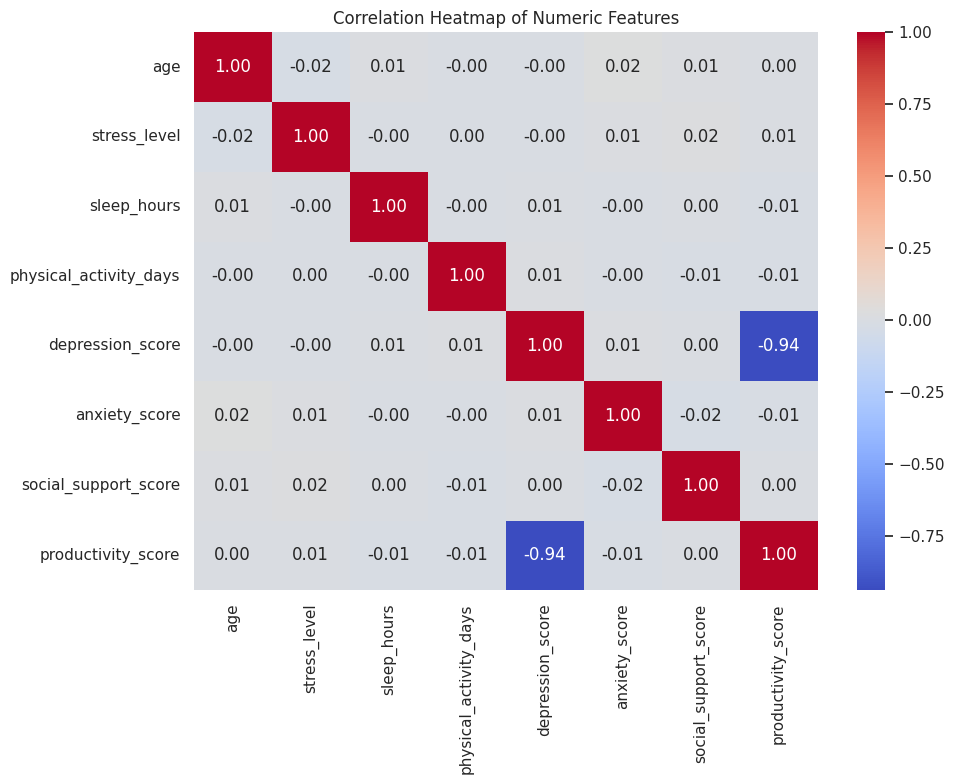

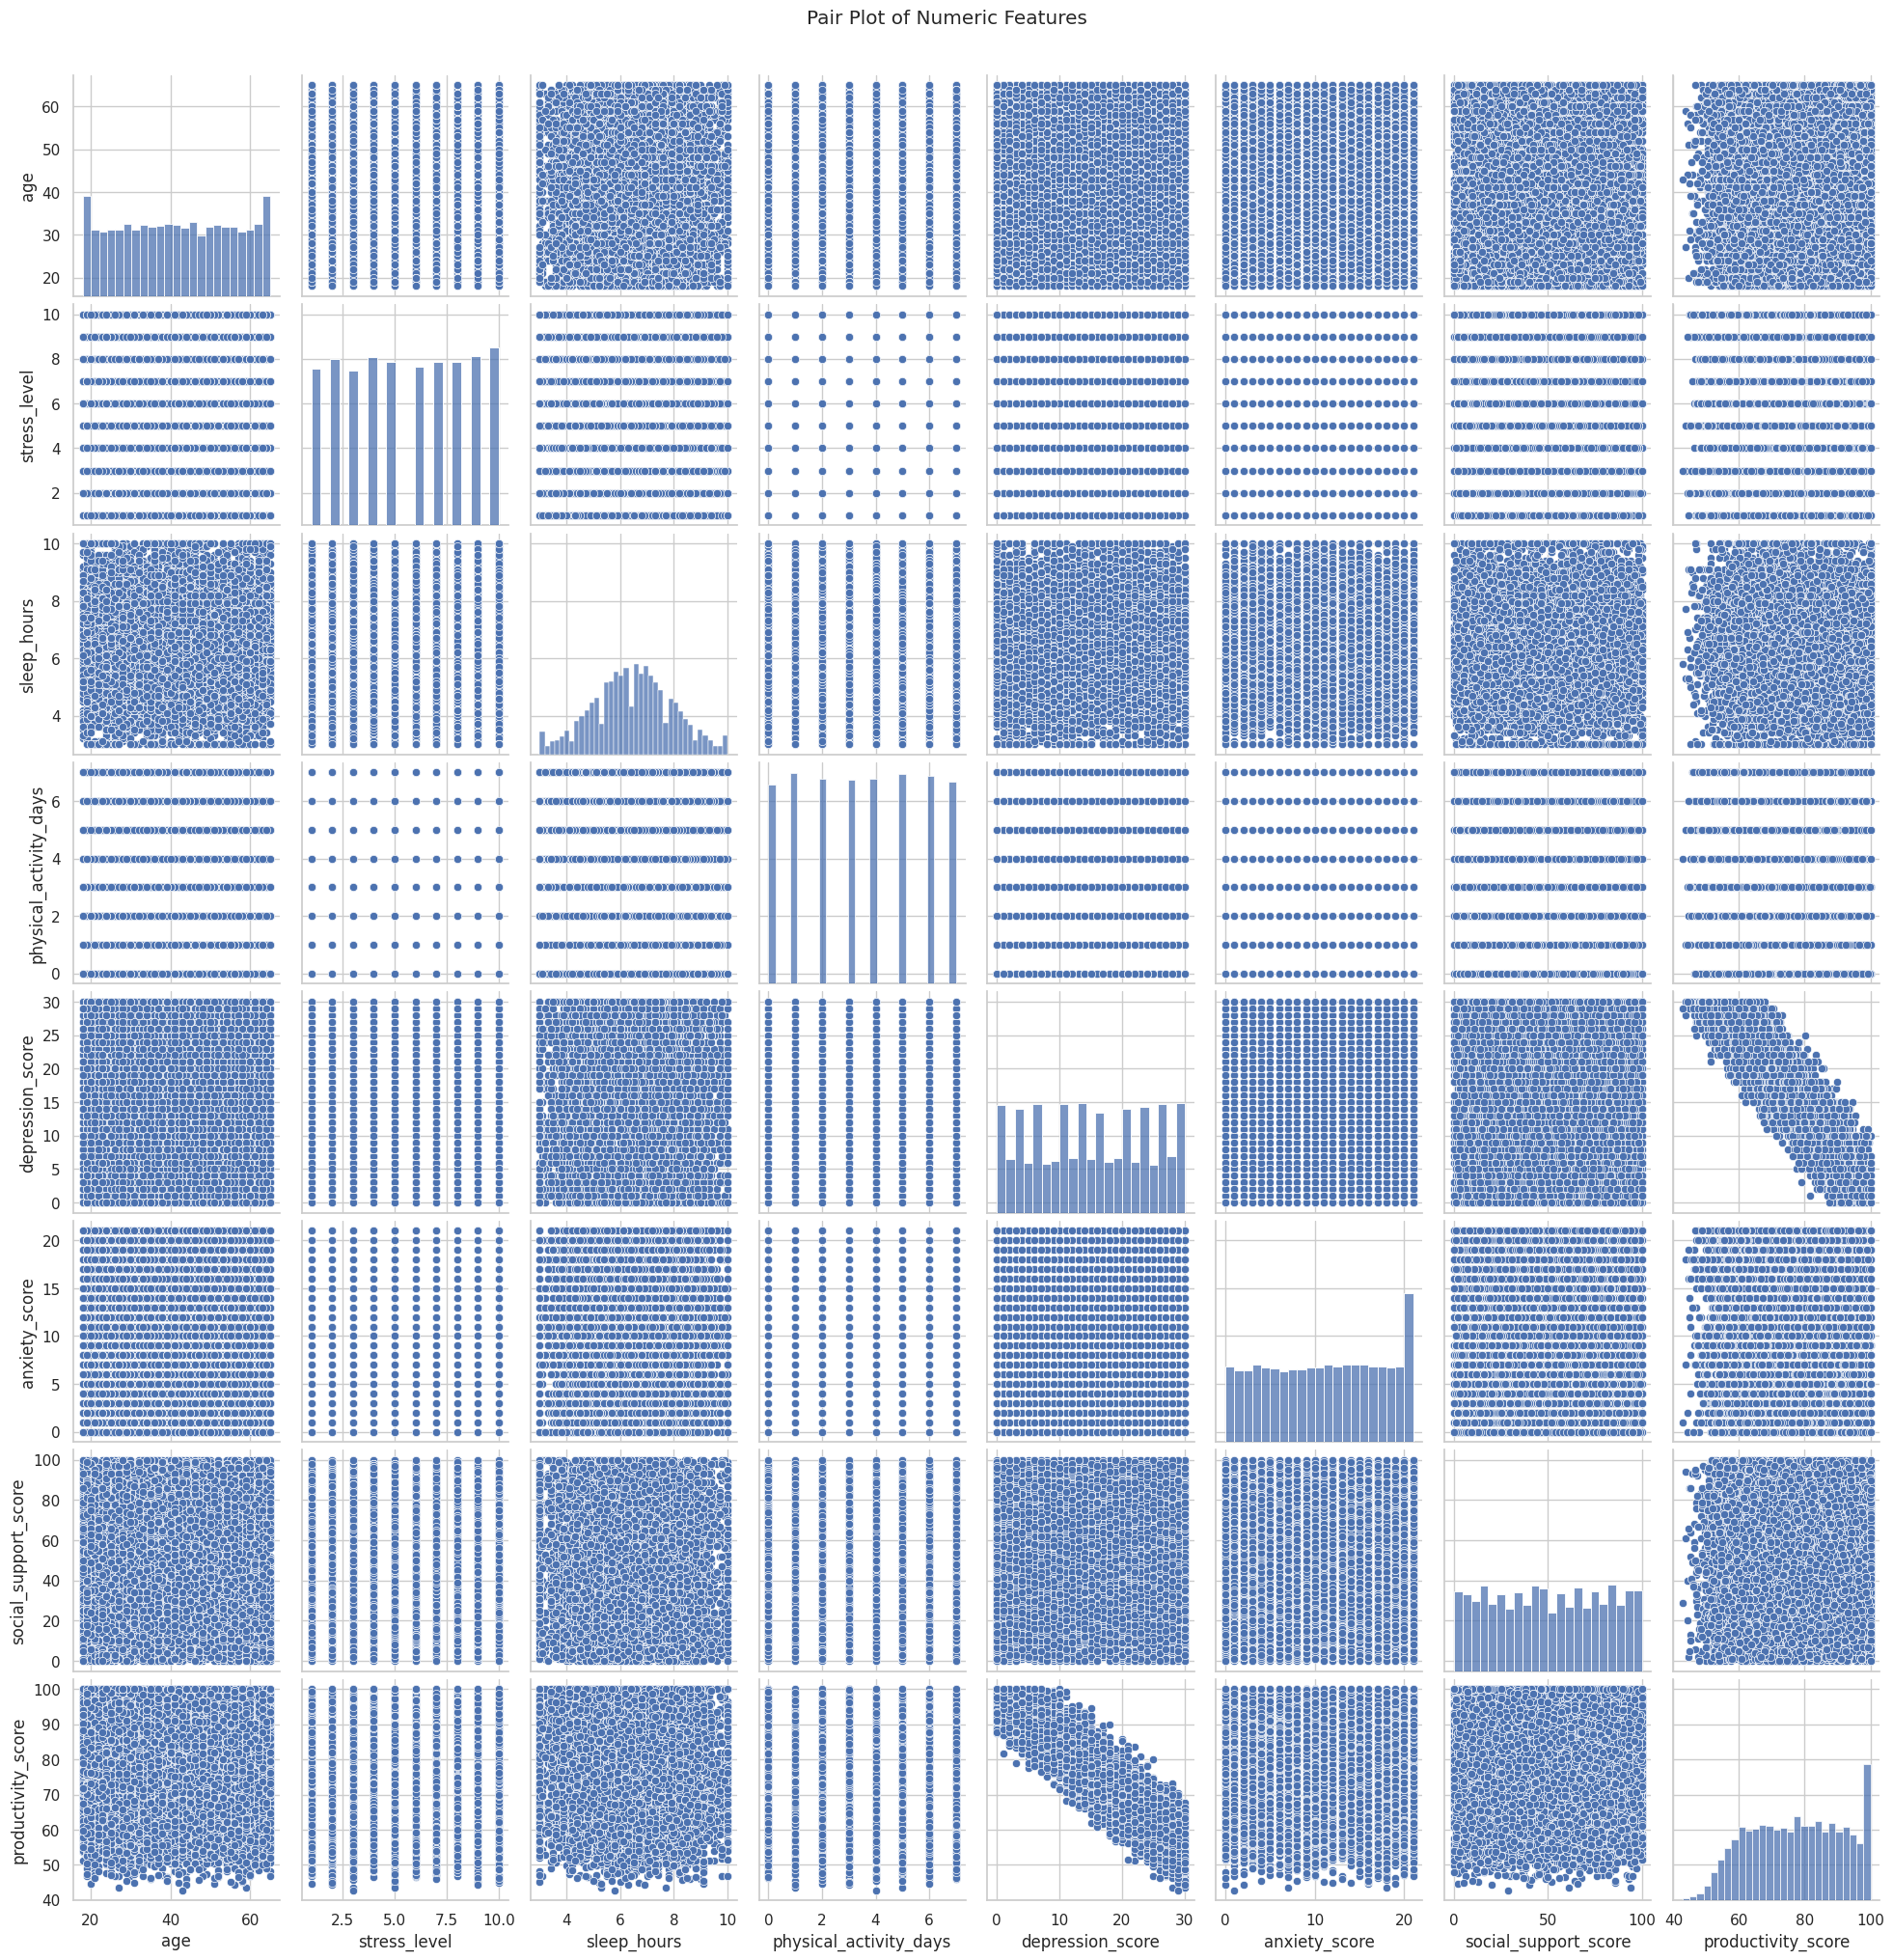

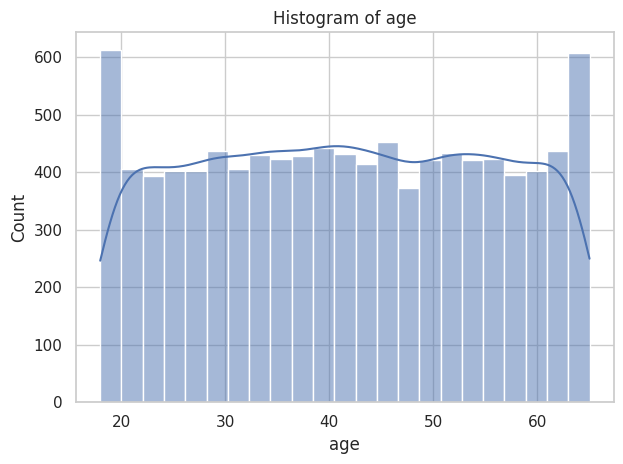

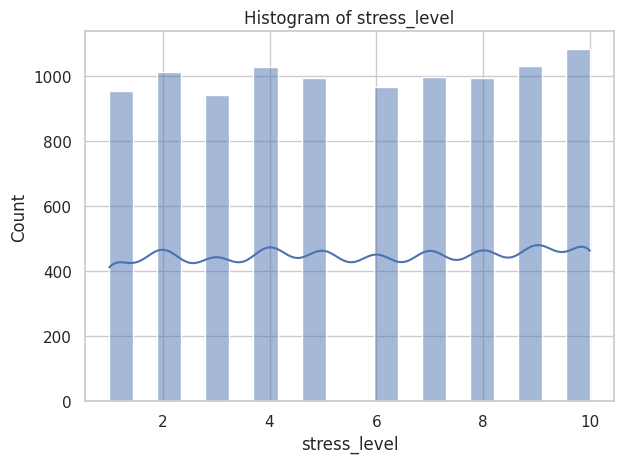

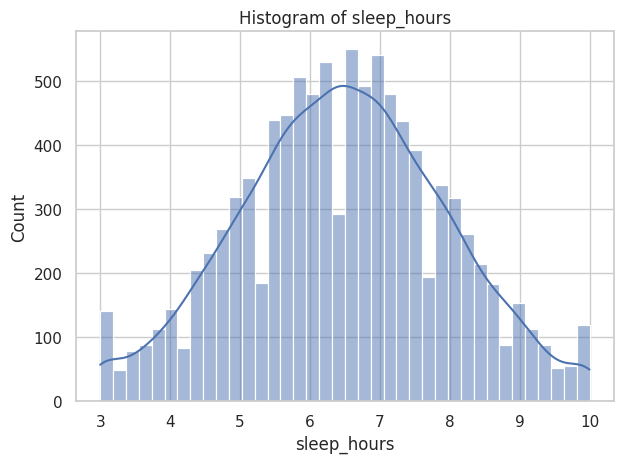

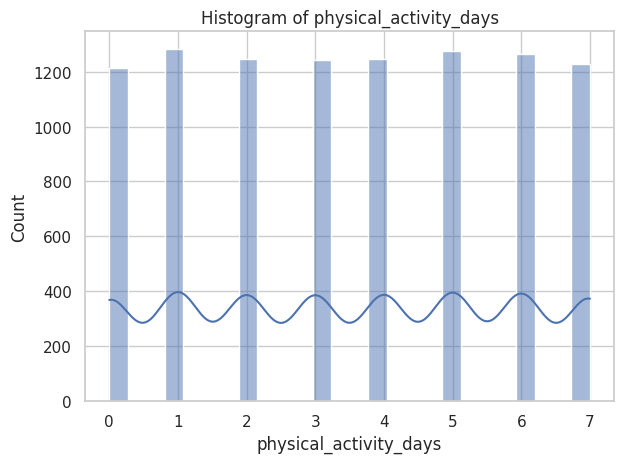

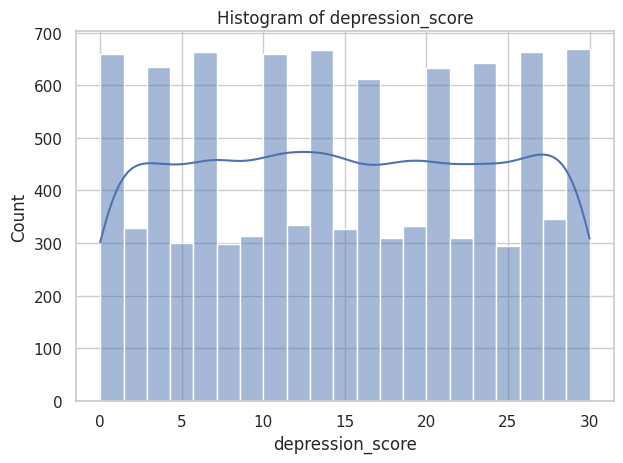

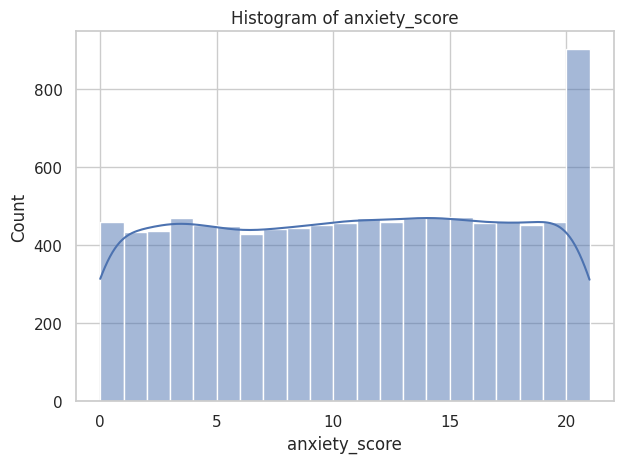

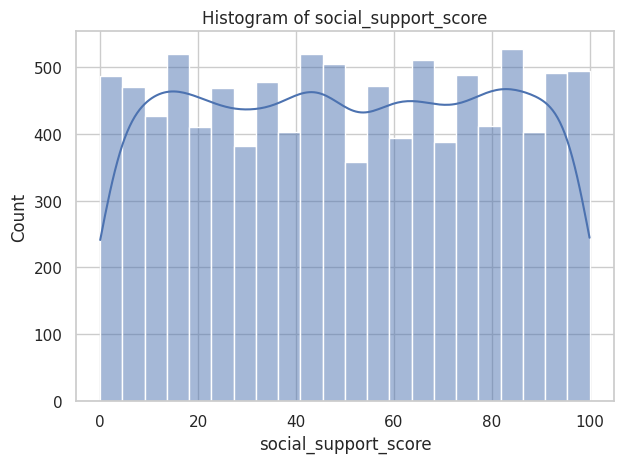

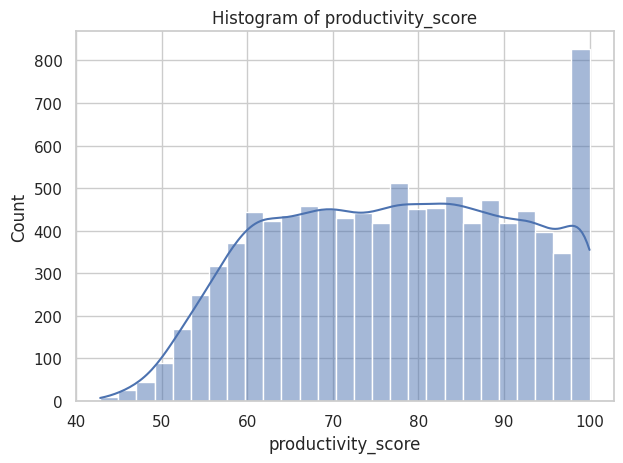

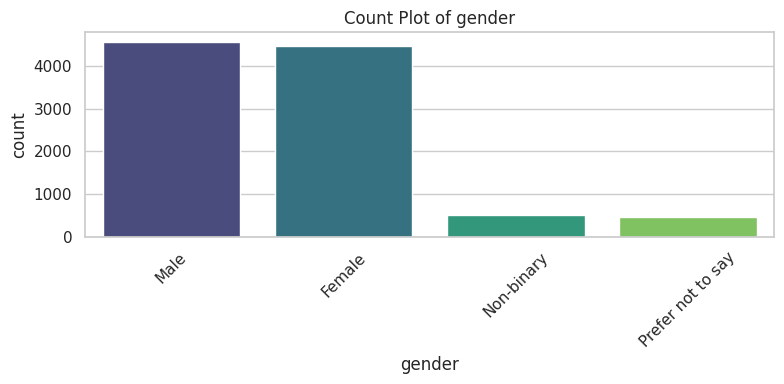

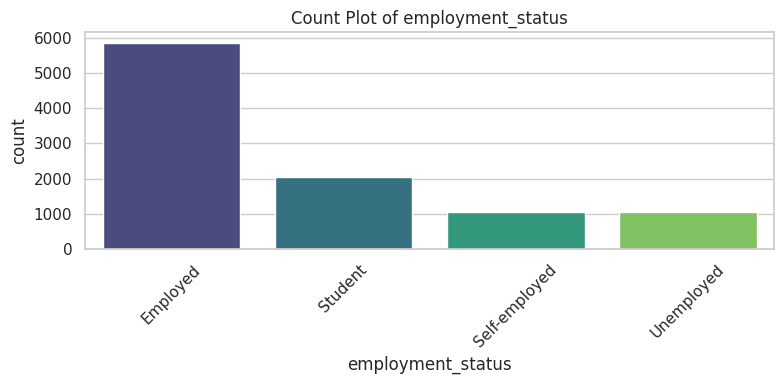

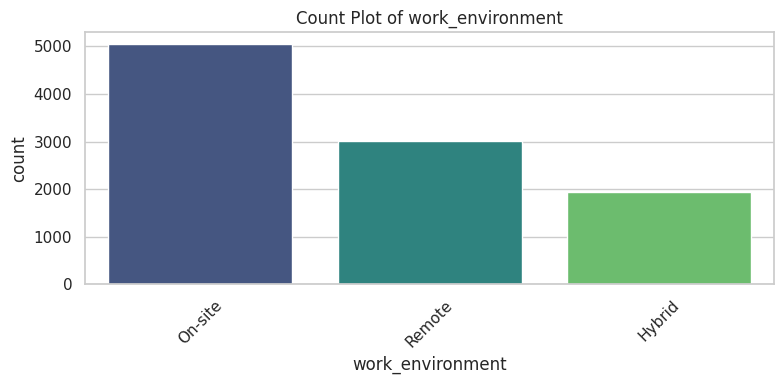

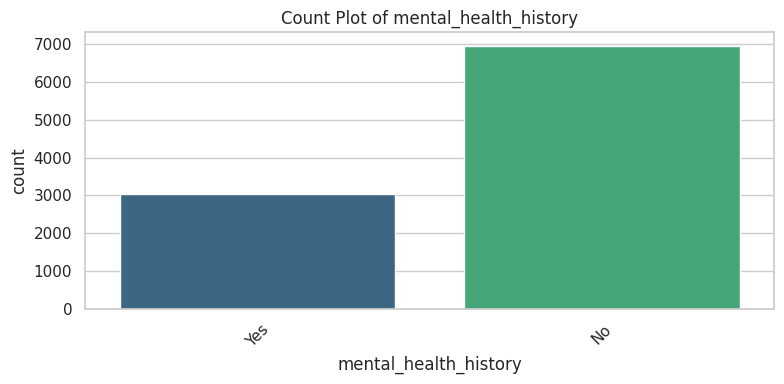

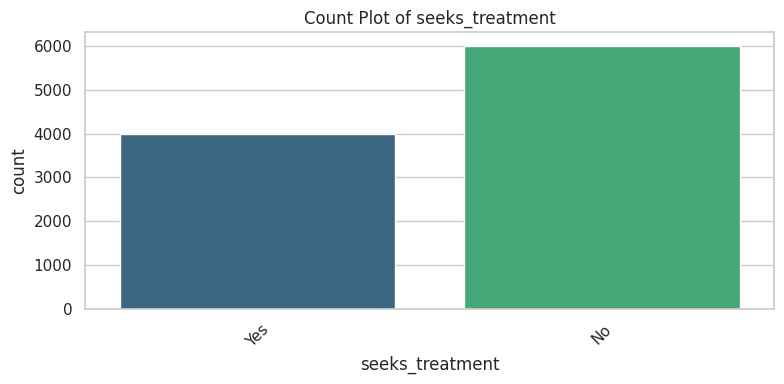

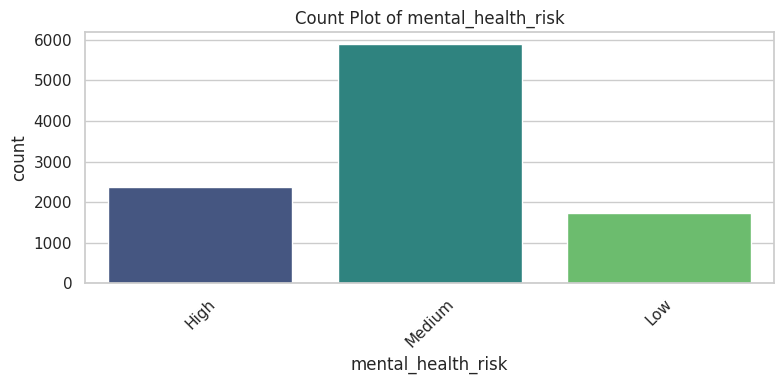

In [7]:
numeric_cols = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days',
                'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score']

categorical_cols = ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment', 'mental_health_risk']

# Visual 1: Correlation heatmap among numeric columns (only if 4 or more exist)
if len(numeric_cols) >= 4:
    numeric_df = df[numeric_cols]
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()

# Visual 2: Pair plot for a few numeric variables
sns.pairplot(df[numeric_cols])
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

# Visual 3: Histograms for distribution of numeric columns
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

# Visual 4: Count plots (pie chart alternative) for categorical features
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Accuracy of the Random Forest Classifier: 0.98


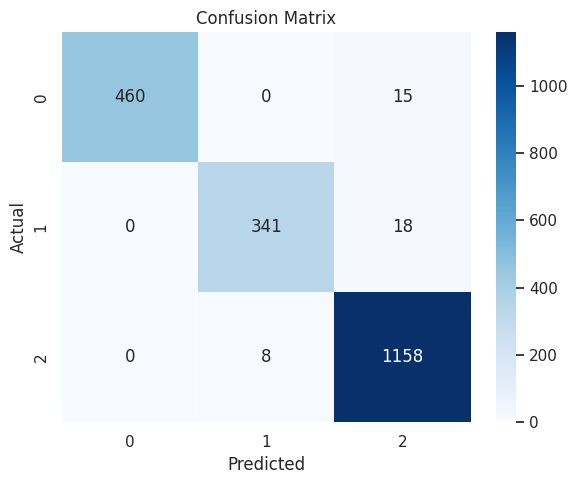

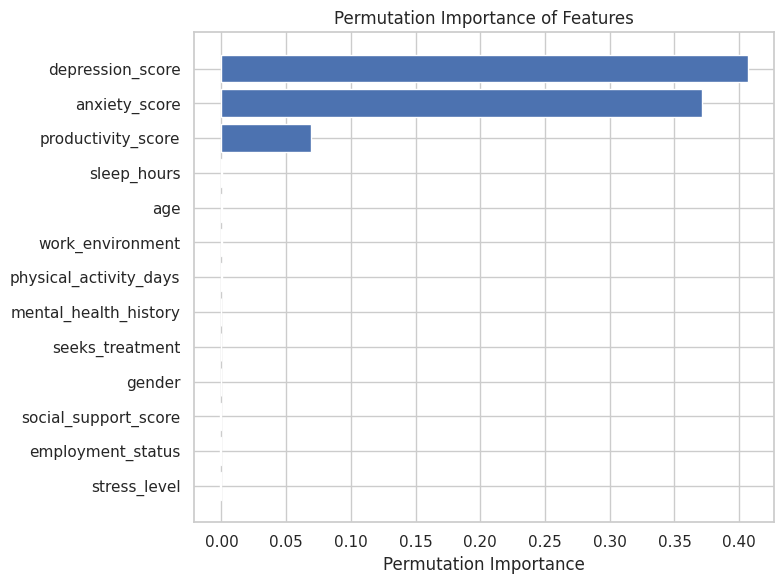

In [8]:
model_df = df.copy()

# List of features to use (for both numeric and categorical predictors)
feature_cols = ['age', 'gender', 'employment_status', 'work_environment',
                'mental_health_history', 'seeks_treatment', 'stress_level',
                'sleep_hours', 'physical_activity_days', 'depression_score',
                'anxiety_score', 'social_support_score', 'productivity_score']

target_col = 'mental_health_risk'

# Encode categorical variables in features
le_dict = {}
for col in model_df[feature_cols].select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    le_dict[col] = le

# Encode the target variable
target_le = LabelEncoder()
model_df[target_col] = target_le.fit_transform(model_df[target_col])

# Split the dataset into features (X) and target (y)
X = model_df[feature_cols]
y = model_df[target_col]

# Scale numeric features to improve model performance
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy score
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest Classifier: {acc:.2f}')

# Plot confusion matrix using heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Compute permutation importance
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_cols)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.tight_layout()
plt.show()